In [ ]:
!pip install devex_sdk

from devex_sdk import setup_runner
setup_runner()

from devex_sdk import Spark_Data_Connector, Nested_Json_Connector
from pyspark.sql.functions import col, count
import pyspark.sql.functions as F

In [13]:
from datetime import datetime
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import collect_list
from datetime import datetime
from matplotlib.dates import DateFormatter

In [14]:
json_object_path = 'prometheus-tsdb-dump/df72.json'
obj = Nested_Json_Connector(json_object_path)
err, df1 = obj.read_nested_json()

Nested_Json_Connector initialized with the following s3_file_path:prometheus-tsdb-dump/df72.json


In [15]:
df

DataFrame[]

In [10]:
from pyspark.sql import functions
from pyspark.sql.functions import expr,from_unixtime
df_date = df.withColumn("date_col",  expr("transform(timestamps, x -> from_unixtime(x / 1000))"))

AnalysisException: [UNRESOLVED_COLUMN.WITHOUT_SUGGESTION] A column or function parameter with name `timestamps` cannot be resolved. ; line 1 pos 10;
'Project ['transform('timestamps, lambdafunction('from_unixtime((lambda 'x / 1000)), lambda 'x, false)) AS date_col#1]
+- LogicalRDD false


### container_memory_max_usage_bytes

In [21]:
df_filter1 = df_date.filter(col("metric_pod").startswith('open5gs-amf-6d85b8c465-fzg2t')).select("metric_pod",'date_col','metric___name__','values').filter((col('metric___name__')=='container_memory_max_usage_bytes'))
# df_filter1.show(df_filter1.count(),truncate=False)

In [22]:
pod11 = df_date.filter(col("metric_pod").startswith('open5gs-amf-6d85b8c465-fzg2t')).select("metric_pod",'date_col','metric___name__','values').filter((col('metric___name__')=='container_memory_max_usage_bytes'))
# pod11.show(df_date.count(),truncate=False)
pod12 = df_date.filter(col("metric_pod").startswith('open5gs-amf-54cc5d554b-pjq4v')).select("metric_pod",'date_col','metric___name__','values').filter((col('metric___name__')=='container_memory_max_usage_bytes'))
# pod12.show(df_date.count(),truncate=False)

In [26]:
def get_pod(pod,valuename):
    
    x_values = pod.select("date_col").rdd.flatMap(lambda x: x).collect()
    y_values = pod.select("values").rdd.flatMap(lambda x: x).collect()
    pod = pod.select("metric_pod").rdd.flatMap(lambda x: x).collect()
    result_dict = {}
    for x_list, y_list in zip(x_values, y_values):
        for x, y in zip(x_list, y_list):
            if x in result_dict:
                result_dict[x] += y
            else:
                result_dict[x] = y

            
    result_dict = {
        datetime.strptime(key, '%Y-%m-%d %H:%M:%S'): value
        for key, value in result_dict.items()
    }

    # Perform operations using the converted dictionary
    sorted_keys = sorted(result_dict.keys())
    d = [(str(key), value) for key, value in result_dict.items()]

    # Create a SparkSession
    spark = SparkSession.builder.getOrCreate()

    # Create a DataFrame from the list of tuples
    df_pod = spark.createDataFrame(d, ['timestamp', valuename])
    # df_pod = df_pod.orderBy(col("timestamp"))

    # Show the DataFrame
    return df_pod

In [27]:
df_pod11 = get_pod(pod11,'container_memory_max_usage_bytes_value')
df_pod12 = get_pod(pod12,'container_memory_max_usage_bytes_value')

In [62]:
def plot(df1,df2, valuename, y_axis_label,n):
    
    # Create a SparkSession
    spark = SparkSession.builder.getOrCreate()

    # Assuming you have two DataFrames or Datasets named df1 and df2 with columns "timestamp" and "value"

    # Aggregate the data by collecting values for each timestamp into a list
    df1_grouped = df1.groupBy("timestamp").agg(collect_list(valuename).alias("values1"))
    df2_grouped = df2.groupBy("timestamp").agg(collect_list(valuename).alias("values2"))

    # Convert timestamp column to a datetime type
    df1_grouped = df1_grouped.withColumn("timestamp", df1_grouped["timestamp"].cast("timestamp"))
    df2_grouped = df2_grouped.withColumn("timestamp", df2_grouped["timestamp"].cast("timestamp"))

    # Collect the data from the DataFrames into the driver node
    data1 = df1_grouped.collect()
    data2 = df2_grouped.collect()

    # Extract the timestamp and value columns
    timestamps1 = [row.timestamp.strftime("%Y-%m-%d %H:%M:%S") for row in data1]
    values1 = [row.values1.pop() for row in data1]
    
    timestamps2 = [row.timestamp.strftime("%Y-%m-%d %H:%M:%S") for row in data2]
    values2 = [row.values2.pop() for row in data2]
    
    # Limit the number of timestamps to plot
    num_timestamps1 = 80
    num_timestamps2 = 10
    step = max(1, len(timestamps1) // num_timestamps1)
    timestamps1 = timestamps1[::step]
    values1 = values1[::step]

    step = max(1, len(timestamps2) // num_timestamps2)
    timestamps2 = timestamps2[::step]
    values2 = values2[::step]

    # Convert timestamps to datetime objects
    timestamps1 = [datetime.strptime(ts, "%Y-%m-%d %H:%M:%S") for ts in timestamps1]
    timestamps2 = [datetime.strptime(ts, "%Y-%m-%d %H:%M:%S") for ts in timestamps2]

    # Sort timestamps in ascending order
    timestamps1, values1 = zip(*sorted(zip(timestamps1, values1)))
    timestamps2, values2 = zip(*sorted(zip(timestamps2, values2)))

    # Create a figure and axes object
    fig, ax = plt.subplots(figsize=(14, 8))

    # Plot the data
    ax.plot_date(timestamps1, values1, '-', color='blue', label='Container:open5gs-amf-6d85b8c465-fzg2t')
    ax.plot_date(timestamps2, values2, '-', color='green', label='Container:open5gs-amf-54cc5d554b-pjq4v')

    # Set x-axis tick format
    date_format = DateFormatter("%H:%M:%S")
    ax.xaxis.set_major_formatter(date_format)

    # Rotate x-axis labels
    fig.autofmt_xdate(rotation=45)
    
    # Add legend and labels
    ax.legend()
    ax.set_xlabel('Timestamp')
    ax.set_ylabel(y_axis_label)
    ax.set_title(n)

    from matplotlib.ticker import FuncFormatter
    # Set y-axis tick format
    def yaxis_formatter(x, pos):
        'The two args are the value and tick position'
        return '%1.1fM' % (x / (1024 ** 2))

    formatter = FuncFormatter(yaxis_formatter)
    ax.yaxis.set_major_formatter(formatter)

    # Display the plot

    plt.show()


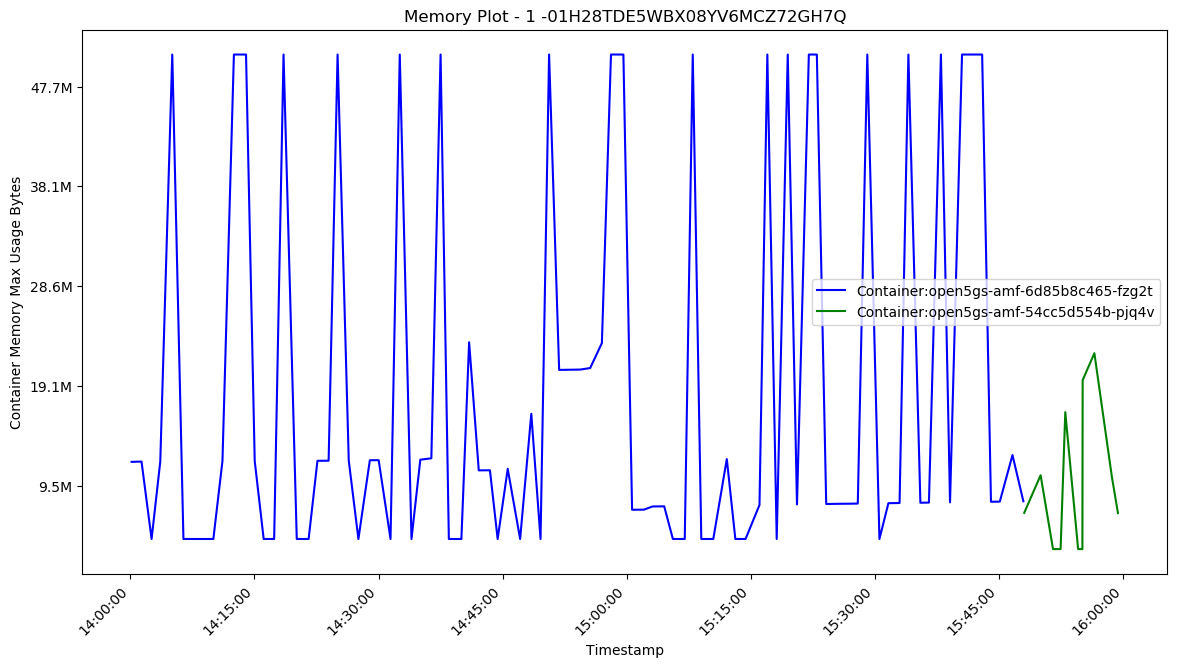

In [63]:
plot(df_pod11,df_pod12,'container_memory_max_usage_bytes_value','Container Memory Max Usage Bytes','Memory Plot - 1 -01H28TDE5WBX08YV6MCZ72GH7Q')

### container_memory_usage_bytes

In [30]:
b = df_date.filter(col("metric_pod").startswith('open5gs-amf')).select("metric_pod",'date_col','metric___name__','values').filter((col('metric___name__')=='container_memory_usage_bytes'))

In [31]:
pod21 = df_date.filter(col("metric_pod").startswith('open5gs-amf-6d85b8c465-fzg2t')).select("metric_pod",'date_col','metric___name__','values').filter((col('metric___name__')=='container_memory_usage_bytes'))
#pod21.show(df_date.count(),truncate=False)
pod22 = df_date.filter(col("metric_pod").startswith('open5gs-amf-54cc5d554b-pjq4v')).select("metric_pod",'date_col','metric___name__','values').filter((col('metric___name__')=='container_memory_usage_bytes'))
#pod22.show(df_date.count(),truncate=False)

In [32]:
df_pod21 = get_pod(pod21,'container_memory_usage_bytes_value')
df_pod22 = get_pod(pod22,'container_memory_usage_bytes_value')

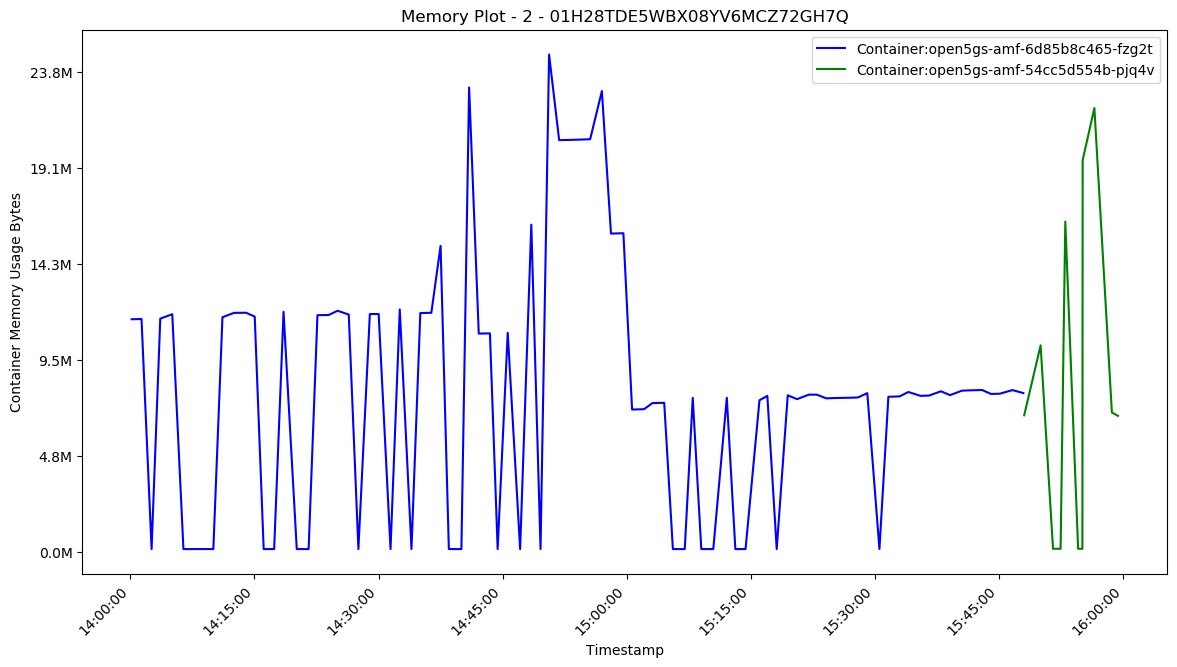

In [71]:
plot(df_pod21,df_pod22,'container_memory_usage_bytes_value','Container Memory Usage Bytes','Memory Plot - 2 - 01H28TDE5WBX08YV6MCZ72GH7Q')

### container_memory_working_set_bytes

In [34]:
c = df_date.filter(col("metric_pod").startswith('open5gs-amf')).select("metric_pod",'date_col','metric___name__','values').filter((col('metric___name__')=='container_memory_working_set_bytes'))

In [35]:
pod31 = df_date.filter(col("metric_pod").startswith('open5gs-amf-6d85b8c465-fzg2t')).select("metric_pod",'date_col','metric___name__','values').filter((col('metric___name__')=='container_memory_working_set_bytes'))
# pod31.show(df_date.count(),truncate=False)
pod32 = df_date.filter(col("metric_pod").startswith('open5gs-amf-54cc5d554b-pjq4v')).select("metric_pod",'date_col','metric___name__','values').filter((col('metric___name__')=='container_memory_working_set_bytes'))
# pod32.show(df_date.count(),truncate=False)

In [36]:
df_pod31 = get_pod(pod31,'container_memory_working_set_bytes_value')
df_pod32 = get_pod(pod32,'container_memory_working_set_bytes_value')

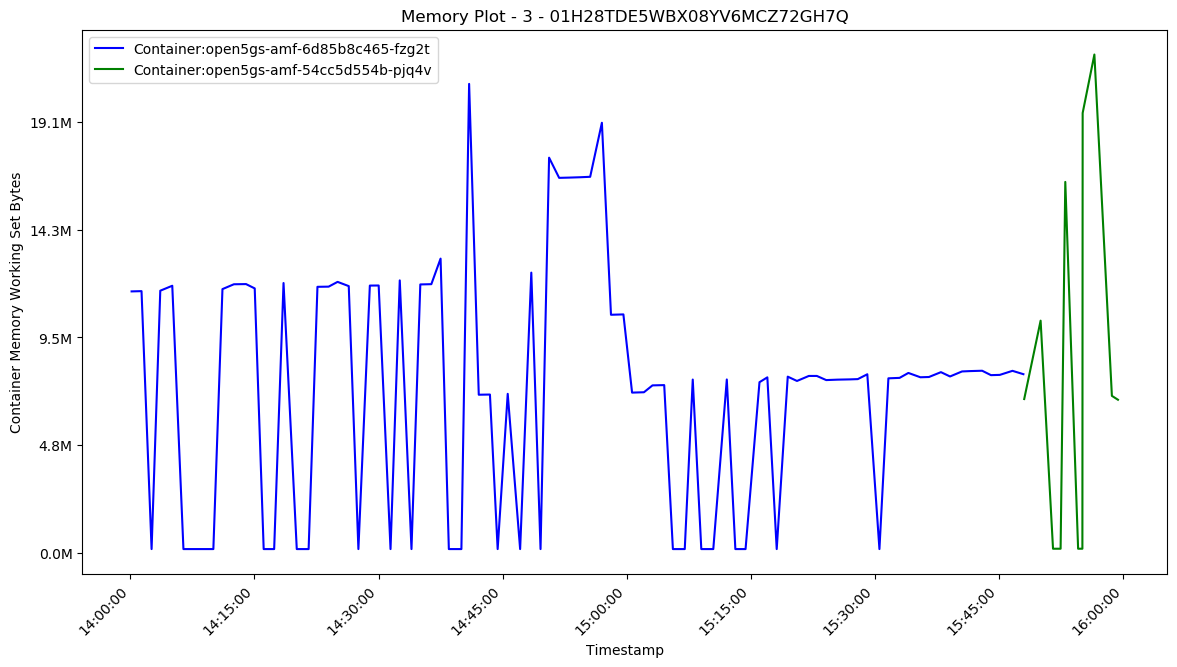

In [65]:
plot(df_pod31,df_pod32,'container_memory_working_set_bytes_value','Container Memory Working Set Bytes','Memory Plot - 3 - 01H28TDE5WBX08YV6MCZ72GH7Q')

### container_memory_cache

In [38]:
h = df_date.filter(col("metric_pod").startswith('open5gs-amf')).select("metric_pod",'date_col','metric___name__','values').filter((col('metric___name__')=='container_memory_cache'))

In [39]:
pod71 = df_date.filter(col("metric_pod").startswith('open5gs-amf-6d85b8c465-fzg2t')).select("metric_pod",'date_col','metric___name__','values').filter((col('metric___name__')=='container_memory_cache'))
# pod31.show(df_date.count(),truncate=False)
pod72 = df_date.filter(col("metric_pod").startswith('open5gs-amf-54cc5d554b-pjq4v')).select("metric_pod",'date_col','metric___name__','values').filter((col('metric___name__')=='container_memory_cache'))
# pod32.show(df_date.count(),truncate=False)

In [40]:
df_pod71 = get_pod(pod71,'container_memory_cache_value')
df_pod72 = get_pod(pod72,'container_memory_cache_value')

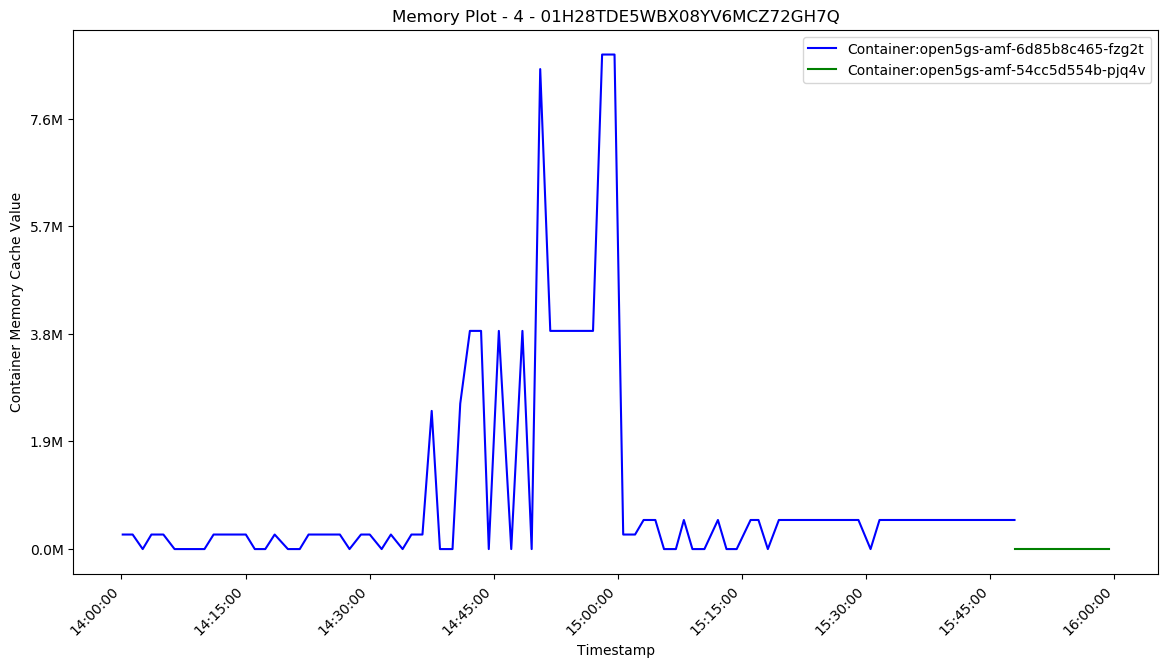

In [66]:
plot(df_pod71,df_pod72,'container_memory_cache_value','Container Memory Cache Value','Memory Plot - 4 - 01H28TDE5WBX08YV6MCZ72GH7Q')

### container_cpu_usage_seconds_total

In [43]:
e = df_date.filter(col("metric_pod").startswith('open5gs-amf')).select("metric_pod",'date_col','metric___name__','values').filter((col('metric___name__')=='container_cpu_usage_seconds_total'))


In [44]:
pod41 = df_date.filter(col("metric_pod").startswith('open5gs-amf-6d85b8c465-fzg2t')).select("metric_pod",'date_col','metric___name__','values').filter((col('metric___name__')=='container_cpu_usage_seconds_total'))
# pod41.show(df_date.count(),truncate=False)
pod42 = df_date.filter(col("metric_pod").startswith('open5gs-amf-54cc5d554b-pjq4v')).select("metric_pod",'date_col','metric___name__','values').filter((col('metric___name__')=='container_cpu_usage_seconds_total'))
# pod42.show(df_date.count(),truncate=False)

In [45]:
df_pod41 = get_pod(pod41,'container_cpu_usage_seconds_total_value')
df_pod42 = get_pod(pod42,'container_cpu_usage_seconds_total_value')

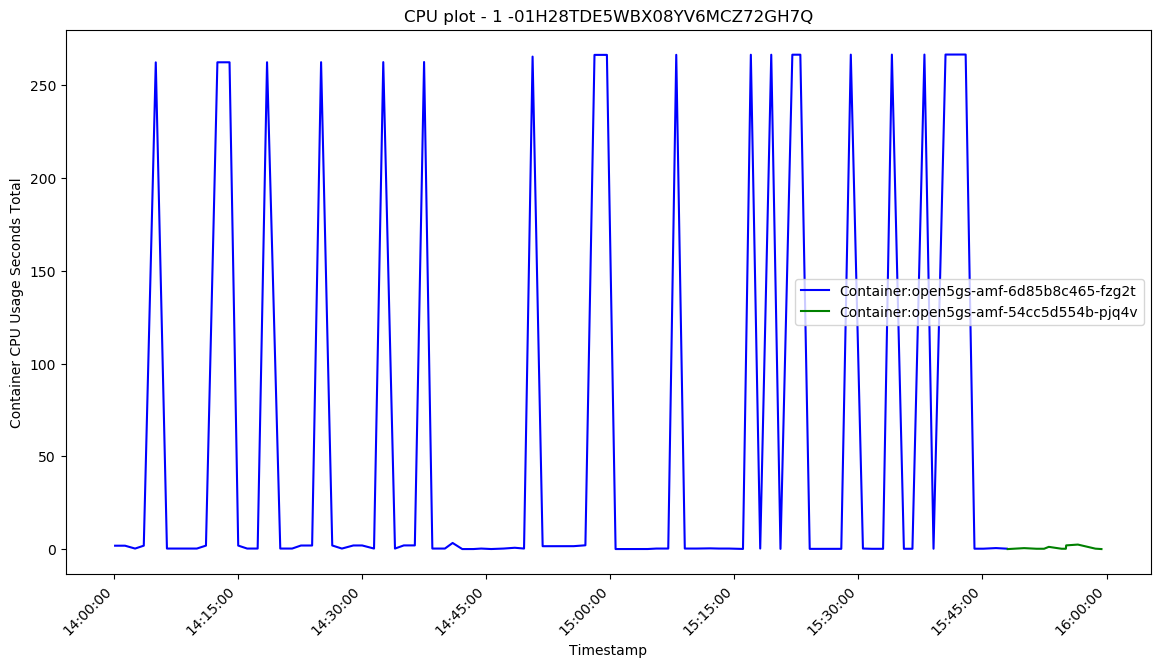

In [67]:
def plot_cpu(df1,df2, valuename, y_axis_label,n):
    
    # Create a SparkSession
    spark = SparkSession.builder.getOrCreate()

    # Assuming you have two DataFrames or Datasets named df1 and df2 with columns "timestamp" and "value"

    # Aggregate the data by collecting values for each timestamp into a list
    df1_grouped = df1.groupBy("timestamp").agg(collect_list(valuename).alias("values1"))
    df2_grouped = df2.groupBy("timestamp").agg(collect_list(valuename).alias("values2"))

    # Convert timestamp column to a datetime type
    df1_grouped = df1_grouped.withColumn("timestamp", df1_grouped["timestamp"].cast("timestamp"))
    df2_grouped = df2_grouped.withColumn("timestamp", df2_grouped["timestamp"].cast("timestamp"))

    # Collect the data from the DataFrames into the driver node
    data1 = df1_grouped.collect()
    data2 = df2_grouped.collect()

    # Extract the timestamp and value columns
    timestamps1 = [row.timestamp.strftime("%Y-%m-%d %H:%M:%S") for row in data1]
    values1 = [row.values1.pop() for row in data1]
    
    timestamps2 = [row.timestamp.strftime("%Y-%m-%d %H:%M:%S") for row in data2]
    values2 = [row.values2.pop() for row in data2]
    
    # Limit the number of timestamps to plot
    num_timestamps1 = 80
    num_timestamps2 = 10
    step = max(1, len(timestamps1) // num_timestamps1)
    timestamps1 = timestamps1[::step]
    values1 = values1[::step]

    step = max(1, len(timestamps2) // num_timestamps2)
    timestamps2 = timestamps2[::step]
    values2 = values2[::step]

    # Convert timestamps to datetime objects
    timestamps1 = [datetime.strptime(ts, "%Y-%m-%d %H:%M:%S") for ts in timestamps1]
    timestamps2 = [datetime.strptime(ts, "%Y-%m-%d %H:%M:%S") for ts in timestamps2]

    # Sort timestamps in ascending order
    timestamps1, values1 = zip(*sorted(zip(timestamps1, values1)))
    timestamps2, values2 = zip(*sorted(zip(timestamps2, values2)))

    # Create a figure and axes object
    fig, ax = plt.subplots(figsize=(14, 8))

    # Plot the data
    ax.plot_date(timestamps1, values1, '-', color='blue', label='Container:open5gs-amf-6d85b8c465-fzg2t')
    ax.plot_date(timestamps2, values2, '-', color='green', label='Container:open5gs-amf-54cc5d554b-pjq4v')

    # Set x-axis tick format
    date_format = DateFormatter("%H:%M:%S")
    ax.xaxis.set_major_formatter(date_format)

    # Rotate x-axis labels
    fig.autofmt_xdate(rotation=45)
    
    # Add legend and labels
    ax.legend()
    ax.set_xlabel('Timestamp')
    ax.set_ylabel(y_axis_label)
    ax.set_title(n)


    # Display the plot

    plt.show()

plot_cpu(df_pod41,df_pod42,'container_cpu_usage_seconds_total_value','Container CPU Usage Seconds Total','CPU plot - 1 -01H28TDE5WBX08YV6MCZ72GH7Q')

### container_cpu_user_seconds_total

In [47]:
f = df_date.filter(col("metric_pod").startswith('open5gs-amf')).select("metric_pod",'date_col','metric___name__','values').filter((col('metric___name__')=='container_cpu_user_seconds_total'))


In [48]:
pod51 = df_date.filter(col("metric_pod").startswith('open5gs-amf-6d85b8c465-fzg2t')).select("metric_pod",'date_col','metric___name__','values').filter((col('metric___name__')=='container_cpu_user_seconds_total'))
# pod51.show(df_date.count(),truncate=False)
pod52 = df_date.filter(col("metric_pod").startswith('open5gs-amf-54cc5d554b-pjq4v')).select("metric_pod",'date_col','metric___name__','values').filter((col('metric___name__')=='container_cpu_user_seconds_total'))
# pod52.show(df_date.count(),truncate=False)

In [49]:
df_pod51 = get_pod(pod51,'container_cpu_user_seconds_total_value')
df_pod52 = get_pod(pod52,'container_cpu_user_seconds_total_value')

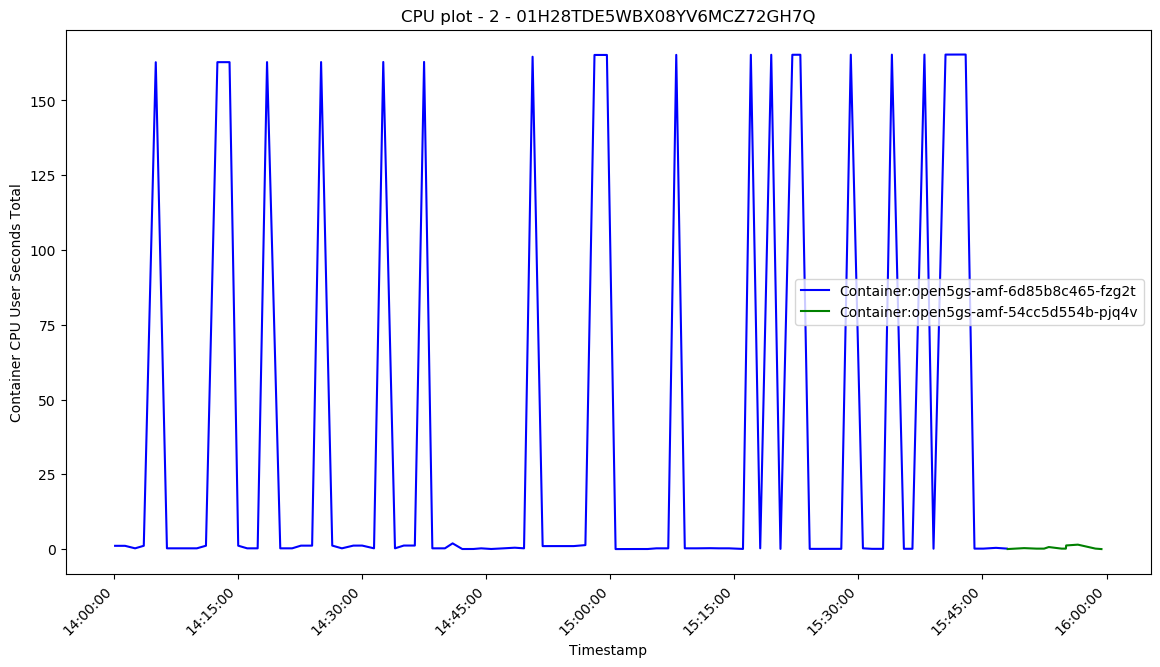

In [68]:
plot_cpu(df_pod51,df_pod52,'container_cpu_user_seconds_total_value','Container CPU User Seconds Total','CPU plot - 2 - 01H28TDE5WBX08YV6MCZ72GH7Q')

### container_processes

In [51]:
g = df_date.filter(col("metric_pod").startswith('open5gs-amf')).select("metric_pod",'date_col','metric___name__','values').filter((col('metric___name__')=='container_processes'))


In [52]:
pod61 = df_date.filter(col("metric_pod").startswith('open5gs-amf-6d85b8c465-fzg2t')).select("metric_pod",'date_col','metric___name__','values').filter((col('metric___name__')=='container_processes'))
# pod61.show(df_date.count(),truncate=False)
pod62 = df_date.filter(col("metric_pod").startswith('open5gs-amf-54cc5d554b-pjq4v')).select("metric_pod",'date_col','metric___name__','values').filter((col('metric___name__')=='container_processes'))
# pod62.show(df_date.count(),truncate=False)

In [53]:
df_pod61 = get_pod(pod61,'container_processes_value')
df_pod62 = get_pod(pod62,'container_processes_value')

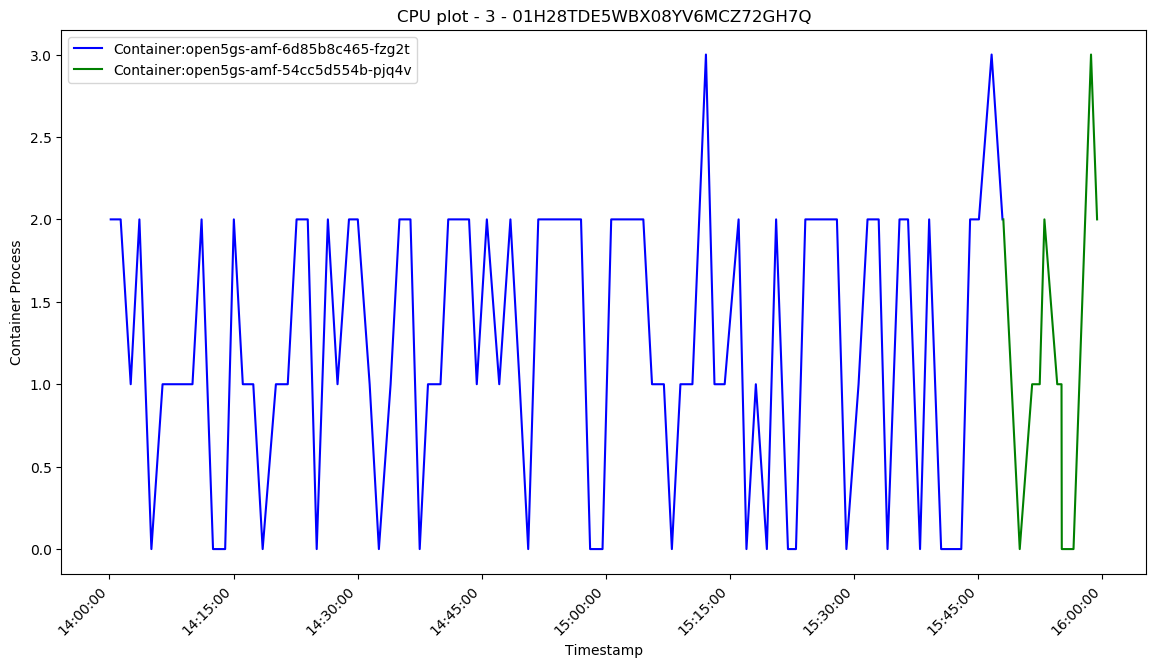

In [69]:
plot_cpu(df_pod61,df_pod62,'container_processes_value','Container Process','CPU plot - 3 - 01H28TDE5WBX08YV6MCZ72GH7Q')

### container_cpu_system_seconds_total

In [55]:
h = df_date.filter(col("metric_pod").startswith('open5gs-amf')).select("metric_pod",'date_col','metric___name__','values').filter((col('metric___name__')=='container_cpu_system_seconds_total'))


In [56]:
pod81 = df_date.filter(col("metric_pod").startswith('open5gs-amf-6d85b8c465-fzg2t')).select("metric_pod",'date_col','metric___name__','values').filter((col('metric___name__')=='container_cpu_system_seconds_total'))
# pod81.show(df_date.count(),truncate=False)
pod82 = df_date.filter(col("metric_pod").startswith('open5gs-amf-54cc5d554b-pjq4v')).select("metric_pod",'date_col','metric___name__','values').filter((col('metric___name__')=='container_cpu_system_seconds_total'))
# pod82.show(df_date.count(),truncate=False)

In [57]:
df_pod81 = get_pod(pod81,'container_cpu_system_seconds_total_value')
df_pod82 = get_pod(pod82,'container_cpu_system_seconds_total_value')

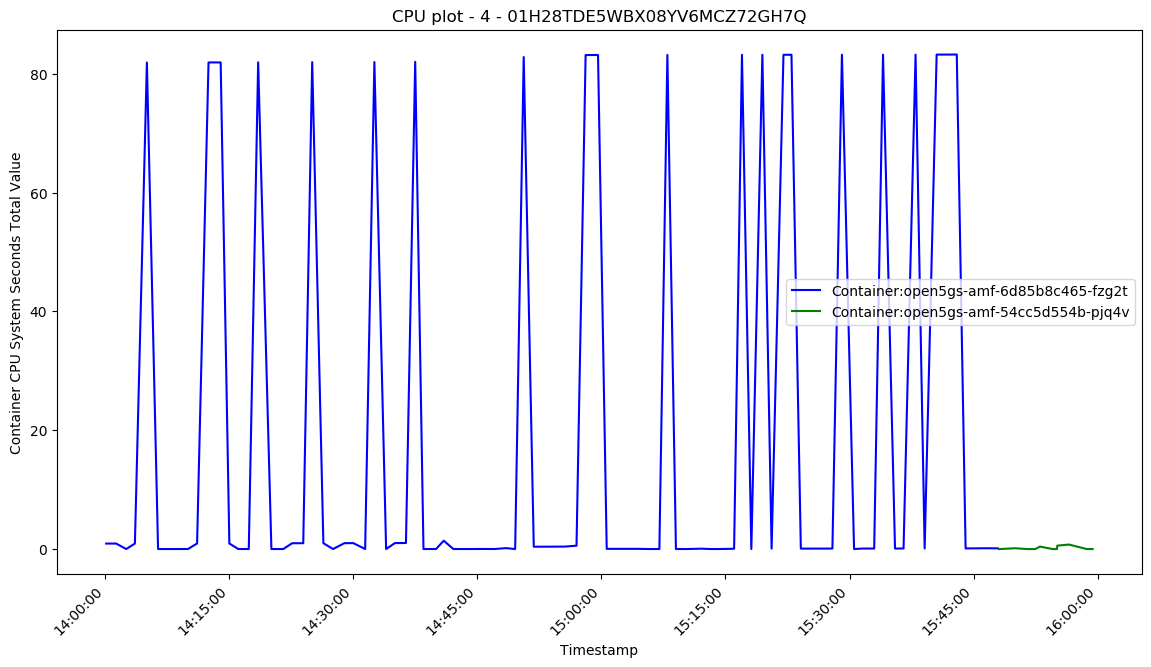

In [70]:
plot_cpu(df_pod81,df_pod82,'container_cpu_system_seconds_total_value','Container CPU System Seconds Total Value','CPU plot - 4 - 01H28TDE5WBX08YV6MCZ72GH7Q')

### Correlation

In [59]:
# Vertically join two DataFrames
merged_df1 = df_pod11.union(df_pod12)
merged_df2 = df_pod21.union(df_pod22)
merged_df3 = df_pod31.union(df_pod32)
merged_df4 = df_pod41.union(df_pod42)
merged_df5 = df_pod51.union(df_pod52)
merged_df6 = df_pod61.union(df_pod62)
merged_df7 = df_pod71.union(df_pod72)
merged_df8 = df_pod81.union(df_pod82)

In [60]:

dataframes = [merged_df1, merged_df2, merged_df3, merged_df7,merged_df4, merged_df5, merged_df6,merged_df8]
merged_df = merged_df1
for df in dataframes[1:]:
    merged_df = merged_df.join(df, 'timestamp')


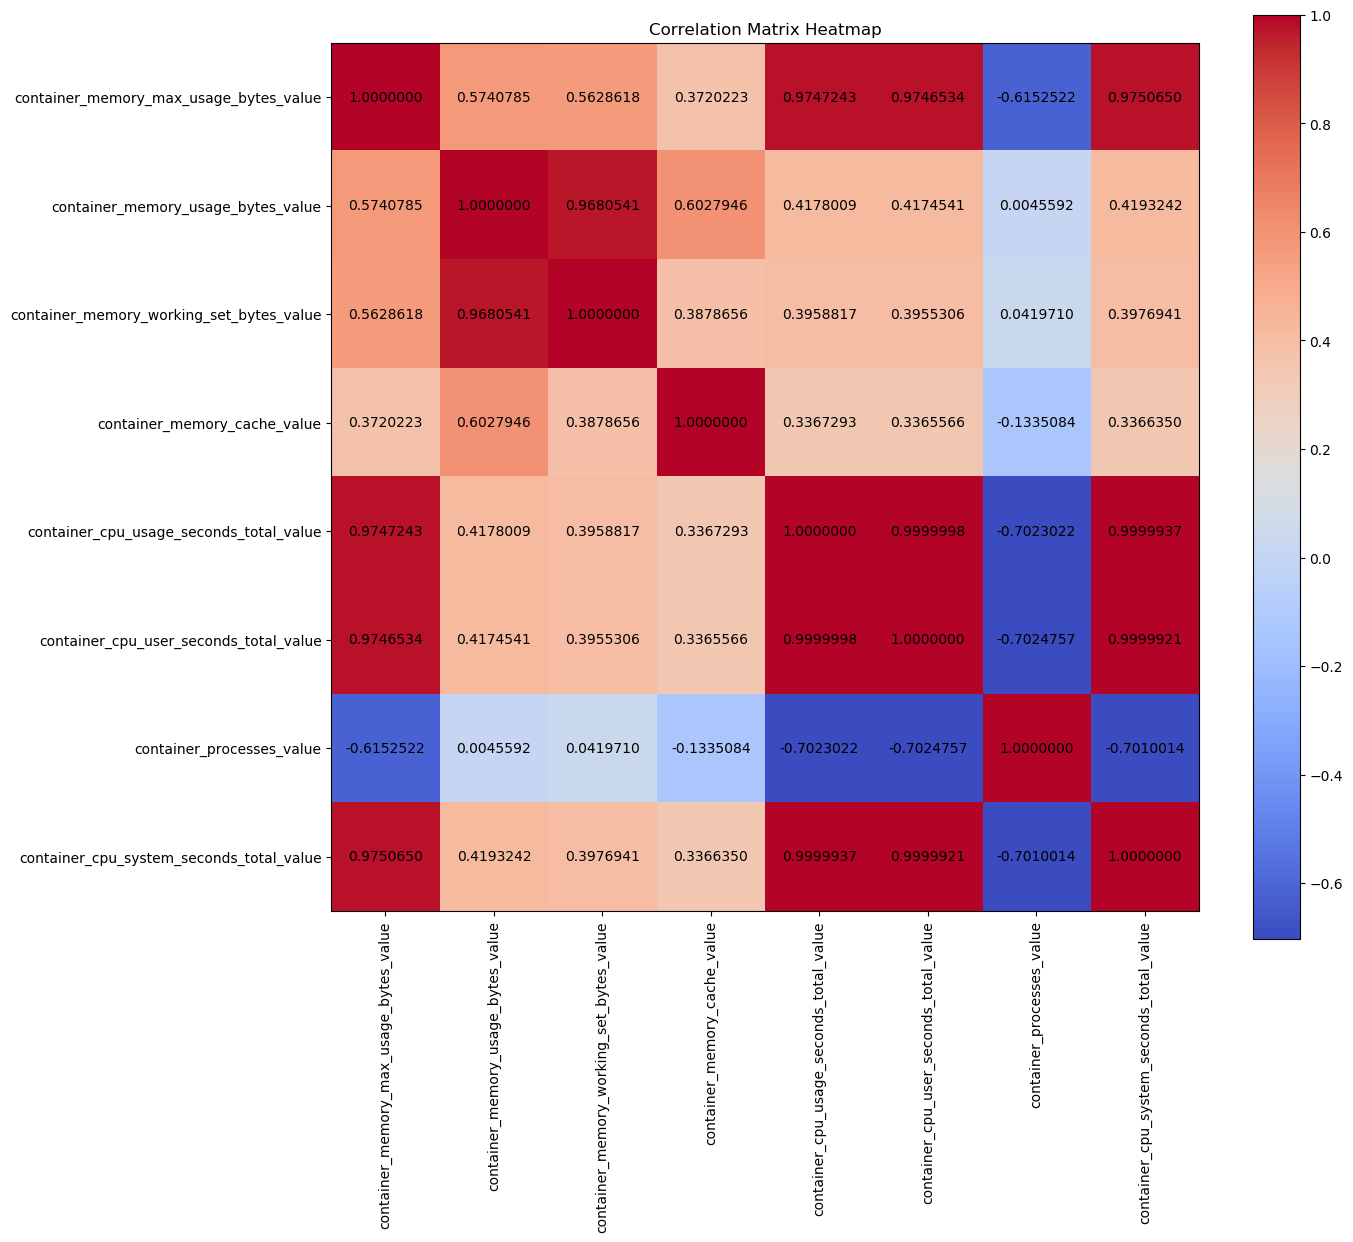

In [61]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
import numpy as np
assembler = VectorAssembler(inputCols=['container_memory_max_usage_bytes_value', 'container_memory_usage_bytes_value', 'container_memory_working_set_bytes_value', 'container_memory_cache_value','container_cpu_usage_seconds_total_value', 'container_cpu_user_seconds_total_value', 'container_processes_value','container_cpu_system_seconds_total_value'],
                            outputCol="features")
features = ['container_memory_max_usage_bytes_value', 'container_memory_usage_bytes_value', 'container_memory_working_set_bytes_value','container_memory_cache_value', 'container_cpu_usage_seconds_total_value', 'container_cpu_user_seconds_total_value', 'container_processes_value','container_cpu_system_seconds_total_value']
                           
# Transform the DataFrame to include the vector column
vector_df = assembler.transform(merged_df).select("features")
# Calculate the correlation matrix
matrix = Correlation.corr(vector_df, "features").head()
# Extract the correlation matrix from the result
correlation_matrix = matrix[0].toArray()

fig, ax = plt.subplots(figsize=(14, 12))
# Create the heatmap using the correlation matrix
heatmap = ax.imshow(correlation_matrix, cmap='coolwarm')
# Add colorbar to the heatmap
cbar = plt.colorbar(heatmap)
# Set the labels for the x and y axes
ax.set_xticks(np.arange(correlation_matrix.shape[1]))
ax.set_yticks(np.arange(correlation_matrix.shape[0]))
ax.set_xticklabels(features, rotation=45)
ax.set_yticklabels(features)
# # Rotate the x-axis labels for better visibility
plt.xticks(rotation=90)
# Add correlation numbers to the heatmap
for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        ax.text(j, i, format(correlation_matrix[i, j], ".7f"), ha='center', va='center', color='black')
# Set the title and show the plot
ax.set_title("Correlation Matrix Heatmap")
plt.show()